In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.spatial.distance import hamming
from sklearn.metrics import mean_squared_error
%matplotlib inline

np.random.seed(42)
matplotlib.rcParams["figure.figsize"] = (18, 15)

In [2]:
data_dir = 'data';
imgs_dir = os.path.join(data_dir, 'house')

In [3]:
images_path = []
for img_path in glob.glob(os.path.join(imgs_dir, '*.png')):
    images_path.append(img_path)
images_path = sorted(images_path)

In [4]:
img1_path = images_path[0]
img2_path = images_path[1]

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

In [5]:
def save_figure(boolean_point_view_matrix, name):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(boolean_point_view_matrix, cmap='Greys')
    ax.set_aspect('auto')
    fig.savefig(name, bbox_inches='tight')

In [6]:
def kps2np(kps):
    return np.array([[keypoint.pt[0], keypoint.pt[1]] for keypoint in kps])

In [7]:
def initialize_matcher(features, crossCheck):
    if features is 'AKAZE':
        return cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    else:
        return cv2.BFMatcher(crossCheck=crossCheck)
    
def initialize_detector(features):
    if features is 'AKAZE':
        return cv2.AKAZE_create()
    else:
        return cv2.xfeatures2d.SIFT_create(contrastThreshold=0.06)

def get_matches(matcher, descs1, descs2, crossCheck):
    if crossCheck:
        return matcher.match(descs1, descs2)
    else:
        return matcher.knnMatch(descs1, descs2, k=2)

def distance_test(match):
    return match[0].distance < 0.8 * match[1].distance

def extract_match(match):
    if isinstance(match, list):
        return match[0]
    else:
        return match
    
def filter_indices(array, indices):
    return np.array([i for i in range(array.shape[0]) if i not in indices])

def sample_keypoints(kps1, kps2, sample_size = 8):
    idxs_sampled = np.random.choice(kps1.shape[0],\
                                   sample_size,\
                                   replace=False)
    idxs_left = list(set(range(kps1.shape[0])) - set(idxs_sampled))
    return kps1[idxs_sampled], kps2[idxs_sampled], kps1[idxs_left], kps2[idxs_left], idxs_sampled, idxs_left

def extract_keypoint_coordinates(matches, kps1, kps2):
    coordinates_a = np.zeros((len(matches), 2))
    coordinates_b = np.zeros((len(matches), 2))
    for i, match in enumerate(matches):
        m = extract_match(match)
        coordinates_a[i] = kps1[m.queryIdx].pt
        coordinates_b[i] = kps2[m.trainIdx].pt
    return coordinates_a, coordinates_b

In [8]:
def calculate_keypoints_and_descriptors(img1, detector):
    (kps1, descs1) = detector.detectAndCompute(img1, None)
    return np.array(kps1), np.array(descs1)

def filter_matches(matches, descs1, descs2, crossCheck):
    good_matches, desc_a, desc_b = [], [], []
    for match in matches:
        if crossCheck or distance_test(match):
            m = extract_match(match)
            good_matches.append([m])
            desc_a.append(descs1[m.queryIdx])
            desc_b.append(descs2[m.trainIdx])
    return good_matches, desc_a, desc_b

In [9]:
def calculate_keypoints_and_matches(img1, img2, features='AKAZE', crossCheck=False):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)    

    detector = initialize_detector(features)

    (kps1, descs1) = calculate_keypoints_and_descriptors(gray1, detector)
    (kps2, descs2) = calculate_keypoints_and_descriptors(gray2, detector)

    print("keypoints: {}, descriptors: {}".format(len(kps1), descs1.shape))
    print("keypoints: {}, descriptors: {}".format(len(kps2), descs2.shape))    

    matcher = initialize_matcher(features, crossCheck)
    matches = get_matches(matcher, descs1, descs2, crossCheck)
        
    good_matches, desc_a, desc_b = filter_matches(matches, descs1, descs2, crossCheck)


    print(f"matched keypoints: {len(good_matches)}")
    
#     return np.array(xa_matches),\
#             np.array(ya_matches),\
#             np.array(xb_matches),\
#             np.array(yb_matches),\
    return kps1, kps2, good_matches,\
            np.array(desc_a), np.array(desc_b)

In [10]:
def eight_points(kps1, kps2):

    xa, ya = kps1.T
    xb, yb = kps2.T
    A = np.vstack((xa*xb, xa*yb, xa, ya*xb, ya*yb, ya, xb, yb, np.ones_like(xa))).T
    U, D, Vh = np.linalg.svd(A, full_matrices=False)

    F = Vh[-1, :].T.reshape(3,3).T
    U_f, D_f, Vh_f = np.linalg.svd(F)
    D_f[-1] = 0.0
    F = U_f @ np.diag(D_f) @ Vh_f
    
    return F

In [11]:
def normalize(x, y):
    mx = np.mean(x)
    my = np.mean(y)

    xt = np.power((x-mx), 2)
    yt = np.power((y-my), 2)

    d = np.mean(np.sqrt(xt + yt))

    T = np.array([[np.sqrt(2)/d, 0,            -mx*(np.sqrt(2)/d)],
                  [0,            np.sqrt(2)/d, -my*(np.sqrt(2)/d)],
                  [0,            0,            1]])
    p = np.vstack((x, y, np.ones_like(x)))
    p_hat = (T @ p).T

    x = p_hat[:,0]
    y = p_hat[:,1]
    
    return T, x, y

def denormalize(F_hat_prime, T, T_prime):
    return T_prime.T @ F_hat_prime @ T

def normalized_eight_points(kps1, kps2, norm=True, denorm=True, T=None, T_prime=None):
    xa, ya = kps1.T
    xb, yb = kps2.T
    if norm:
        T, xa, ya = normalize(xa, ya)
        T_prime, xb, yb = normalize(xb, yb)
    
    kps1 = np.vstack((xa,ya)).T
    kps2 = np.vstack((xb,yb)).T
    F_hat_prime = eight_points(kps1, kps2)
    if denorm:
        F = denormalize(F_hat_prime, T, T_prime)
        return F, F_hat_prime
    else:
        return F_hat_prime

keypoints: 497, descriptors: (497, 61)
keypoints: 496, descriptors: (496, 61)
matched keypoints: 451


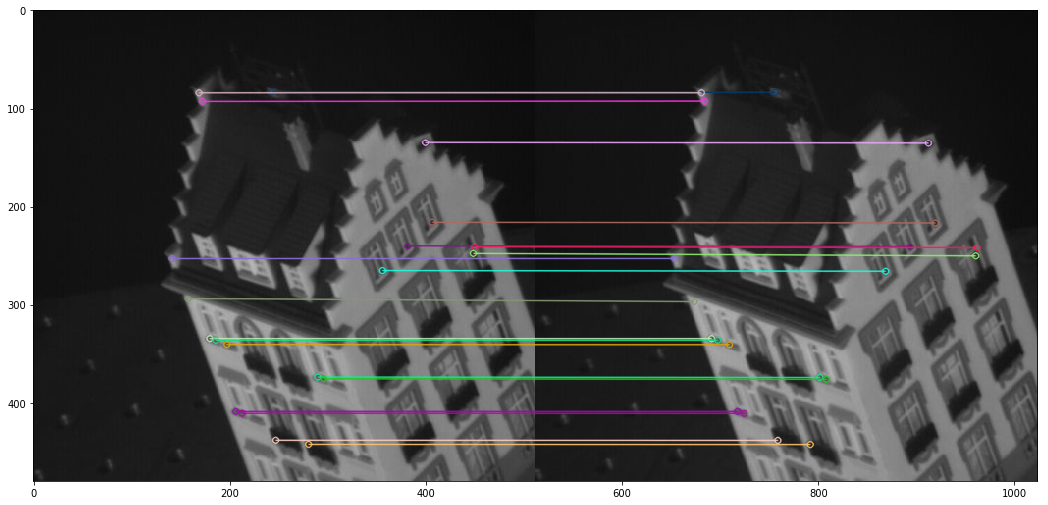

In [14]:
kps1, kps2, good_matches, _, _ = calculate_keypoints_and_matches(img1, img2, features = 'AKAZE', crossCheck=True)

# cv2.drawMatchesKnn expects list of lists as matches.
im3 = cv2.drawMatchesKnn(img1, kps1, img2, kps2, good_matches[:20], None, flags=2)
plt.imshow(im3)
plt.show()

In [15]:
sample_size = 8

kps1, kps2, good_matches, _, _ = calculate_keypoints_and_matches(img1, img2, features='SIFT', crossCheck=False)
coordinates1, coordinates2 = extract_keypoint_coordinates(good_matches, kps1, kps2)

kps1_sampled, kps2_sampled, _, _, _, _ = sample_keypoints(coordinates1, coordinates2)

pts1 = np.hstack((kps1_sampled, np.ones((kps1_sampled.shape[0], 1)))).T
pts2 = np.hstack((kps2_sampled, np.ones((kps2_sampled.shape[0], 1)))).T

keypoints: 295, descriptors: (295, 128)
keypoints: 298, descriptors: (298, 128)
matched keypoints: 253


In [16]:
xa, ya = kps1_sampled.T
_, xa_norm, ya_norm = normalize(xa, ya)
mx = np.mean(xa_norm)
my = np.mean(ya_norm)

xt = np.power((xa_norm-mx), 2)
yt = np.power((ya_norm-my), 2)

d = np.mean(np.sqrt(xt + yt))

print(f'Mean: ({mx},{my})')
print(f'Distance to mean - sqrt(2): {d - np.sqrt(2)}')

Mean: (-8.326672684688674e-17,1.1102230246251565e-16)
Distance to mean - sqrt(2): -2.220446049250313e-16


In [17]:
F = eight_points(kps1_sampled, kps2_sampled)

print('Resulting values:')
for i in range(pts1.shape[1]):
    point_a = pts1[:, i]
    point_b = pts2[:, i]
    print(point_b @ F @ point_a.T)

Resulting values:
-0.16395806357902387
-0.0218911533329047
-0.09150270171863895
-0.11898355629835322
-0.11905328456073505
-0.07703172206200293
-0.12723781318480576
-0.12881151773054667


In [18]:
F, F_hat_prime = normalized_eight_points(kps1_sampled, kps2_sampled)

print('Resulting values:')
for i in range(pts1.shape[1]):
    point_a = pts1[:, i]
    point_b = pts2[:, i]
    print(point_b @ F @ point_a.T)

Resulting values:
0.0015395597034790764
0.0009167461683292633
0.0025026985096303633
0.0021718801579551084
0.001293918221228152
0.00049731270742992
-0.0004881008900561312
-0.00023232409041229474


In [19]:
def sampson_distance(kpt1, kpt2, F_hat_prime):
#     print(kpt1, kpt1.shape, kpt2, kpt2.shape)
    d = np.power(kpt2 @ F_hat_prime @ kpt1, 2)
    sqr_kpt1 = np.power(F_hat_prime @ kpt1, 2)
    sqr_kpt2 = np.power(F_hat_prime.T @ kpt2, 2)
    d /= (sqr_kpt1[0] + sqr_kpt1[1] + sqr_kpt2[0] + sqr_kpt2[1])
    return d

In [20]:
def RANSAC_eight_points(kps1, kps2, sample_size=8):
    N = 100
#     print(f'Number of iterations {N}')

    xa_matches, ya_matches = kps1.T
    xb_matches, yb_matches = kps2.T
    
    T_a, xa_norm, ya_norm = normalize(xa_matches, ya_matches)
    T_b, xb_norm, yb_norm = normalize(xb_matches, yb_matches)
   
    best_inliers = 0
    best_error = 0
    best_mask = []
    best_idxs = []

    for i in range(N):
        _, _, _, _, idxs_sampled, idxs_left = sample_keypoints(kps1, kps2)
        
        kps1_sampled = np.vstack((xa_norm[idxs_sampled],ya_norm[idxs_sampled])).T
        kps2_sampled = np.vstack((xb_norm[idxs_sampled],yb_norm[idxs_sampled])).T
        
        kps1_left = np.vstack((xa_norm[idxs_left],ya_norm[idxs_left])).T
        kps2_left = np.vstack((xb_norm[idxs_left],yb_norm[idxs_left])).T
        
        F_hat_prime = normalized_eight_points(kps1_sampled, kps2_sampled, norm=False, denorm=False)

        inliers = 0
        total_error = 0
        mask = []
        
        pts1 = np.hstack((kps1_left, np.ones((kps1_left.shape[0], 1)))).T
        pts2 = np.hstack((kps2_left, np.ones((kps2_left.shape[0], 1)))).T

        for i in range(pts1.shape[1]):
            point_a = pts1[:, i]
            point_b = pts2[:, i]

            distance = sampson_distance(point_a, point_b, F_hat_prime)
#             print(distance)
            if distance < 1e-4:
                inliers += 1
                total_error += distance
                mask.append(True)
            else:
                mask.append(False)
                
        if (inliers > best_inliers) or (inliers == best_inliers and total_error < best_error):
            best_inliers = inliers
            best_error = total_error
            best_mask = np.array(mask)
            best_idxs = np.array(idxs_left)[mask]

        best_kps1 = np.vstack((xa_norm[best_idxs], ya_norm[best_idxs])).T
        best_kps2 = np.vstack((xb_norm[best_idxs], yb_norm[best_idxs])).T
        
#     print(f"Number of final inliers: {best_inliers}")
    F, F_hat_prime = normalized_eight_points(best_kps1, best_kps2, norm=False, denorm=True, 
                                         T=T_a, T_prime=T_b)
    return F, F_hat_prime, best_idxs

In [21]:
F, F_hat_prime, best_idxs = RANSAC_eight_points(coordinates1, coordinates2)

In [22]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, _ = img1.shape
    
    img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2BGR)
    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        
        color = tuple(np.random.randint(0,255,3).tolist())
        
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        
        
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
        
    return img1,img2

In [23]:
def draw_epipolar_lines(img1, img2, pts1, pts2, F):
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img5,img6 = drawlines(img1, img2, lines1, pts1, pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2, img1, lines2, pts2, pts1)

    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

In [24]:
def demo_epipolar_coordinates(img1_path, img2_path, method='RANSAC', sample_size=10, features='AKAZE', crossCheck=False):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    kps1, kps2, good_matches, _, _ = calculate_keypoints_and_matches(img1, img2, features, crossCheck)
    pts1, pts2 = extract_keypoint_coordinates(good_matches, kps1, kps2)
    
    if method is 'RANSAC':
        F, F_hat_prime, best_idxs = RANSAC_eight_points(pts1, pts2, sample_size)
        pts1 = pts1[best_idxs]
        pts2 = pts2[best_idxs]
        
    elif method is 'NORM':
        kps1_sampled, kps2_sampled, _, _, _, _ = sample_keypoints(pts1, pts2)
        F, F_hat_prime = normalized_eight_points(kps1_sampled, kps2_sampled)
    else:
        kps1_sampled, kps2_sampled, _, _, _, _ = sample_keypoints(pts1, pts2)
        F = eight_points(kps1_sampled, kps2_sampled)
        
    pts1 = pts1.astype(int)
    pts2 = pts2.astype(int)
    draw_epipolar_lines(img1, img2, pts1, pts2, F)
    return F

keypoints: 497, descriptors: (497, 61)
keypoints: 527, descriptors: (527, 61)
matched keypoints: 311


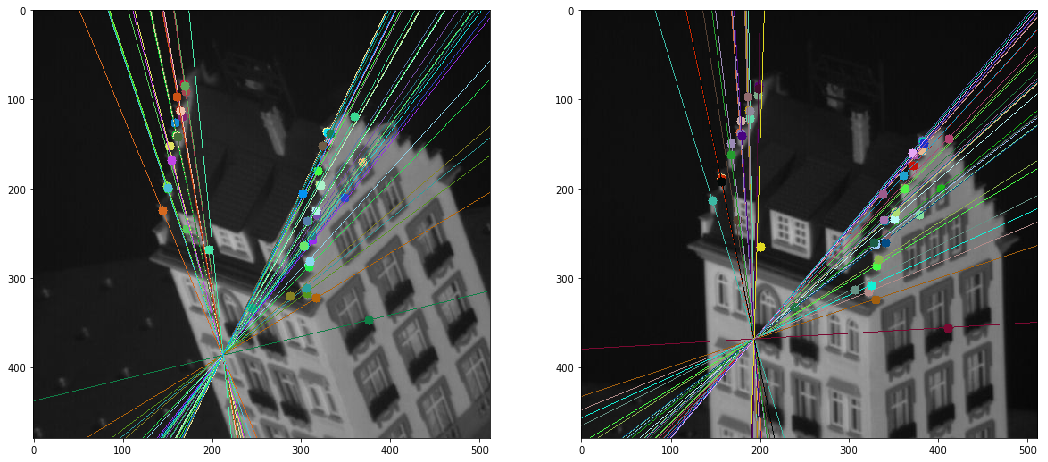

Fundamental matrix is: [[-8.10996432e-06 -4.90198842e-05  2.07137259e-02]
 [ 6.10111189e-05 -9.45777100e-06 -9.29109781e-03]
 [-2.09587327e-02  1.29962008e-02 -5.84636333e-01]]


In [25]:
F = demo_epipolar_coordinates(images_path[0], images_path[-1], sample_size=15, crossCheck=True, features = 'AKAZE')

print(f'Fundamental matrix is: {F}')

In [26]:
def build_pvm(images_path, number_of_images_used = 50, method = 'RANSAC', features = 'AKAZE',\
              crossCheck = False, distance_threshold = 5,  step=1, sample_size = 8):
    images_part = images_path[:number_of_images_used]
#     images_part.append(images_path[0])
    all_descriptors = {}

    img_path = images_path[0]
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    detector = initialize_detector(features)
    (kps, descs) = calculate_keypoints_and_descriptors(gray_img, detector) 
    keypoints = kps2np(kps)
    all_descriptors[0] = descs
    
    num_rows = int(len(images_part)/step) + (1 if step != 1 else 0)
    point_view_matrix = np.zeros((num_rows, keypoints.shape[0], 2))
    boolean_point_view_matrix = np.zeros((num_rows, keypoints.shape[0])).astype(bool)
    point_view_matrix[0] = keypoints 
    boolean_point_view_matrix[0] = True

    for i, image_path in enumerate(tqdm(images_part[1::step]), 1):

        previous_row_existing_idxs = np.where(boolean_point_view_matrix[i-1, :])[0]
        keypoints1 = point_view_matrix[i-1, previous_row_existing_idxs, :]

        img = cv2.imread(image_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        (kps, descs) = calculate_keypoints_and_descriptors(gray_img, detector) 
        keypoints2 = kps2np(kps)
        
        matcher = initialize_matcher(features, crossCheck)
        matches = get_matches(matcher, all_descriptors[i-1], descs, crossCheck)

        query_idxs = []
        train_idxs = []

        for match in matches:
            if not crossCheck:
                query_keypoint = keypoints1[match[0].queryIdx]
                train_keypoint = keypoints2[match[0].trainIdx]
            else:
                query_keypoint = keypoints1[match.queryIdx]
                train_keypoint = keypoints2[match.trainIdx]

            if (crossCheck or match[0].distance < 0.8 * match[1].distance) and np.all(np.abs(query_keypoint - train_keypoint) < distance_threshold):
                if isinstance(match, list):
                    m = match[0]
                else:
                    m = match

                query_idxs.append(m.queryIdx)
                train_idxs.append(m.trainIdx)
                
        query_idxs = np.array(query_idxs)
        train_idxs = np.array(train_idxs)
        
        if method is 'RANSAC':
            _, _, best_idxs = RANSAC_eight_points(keypoints1[query_idxs], keypoints2[train_idxs], sample_size)
            
            query_idxs = query_idxs[best_idxs]
            train_idxs = train_idxs[best_idxs]

        train_left_indices = filter_indices(keypoints2, train_idxs)
        matched_indices_query = previous_row_existing_idxs[query_idxs]

        matching_row = np.zeros((point_view_matrix.shape[1], 2))
        matching_row[matched_indices_query] = keypoints2[train_idxs]

        boolean_matching_row = np.zeros((boolean_point_view_matrix.shape[1])).astype(np.bool)
        boolean_matching_row[matched_indices_query] = True

        point_view_matrix[i] = matching_row
        boolean_point_view_matrix[i] = boolean_matching_row

        train_left_keypoints = keypoints2[train_left_indices]

        padding = np.zeros((point_view_matrix.shape[0], train_left_keypoints.shape[0], 2))
        padding[i] = train_left_keypoints
        bool_padding = np.zeros((point_view_matrix.shape[0], train_left_keypoints.shape[0]))
        bool_padding[i] = True

        point_view_matrix = np.hstack((point_view_matrix, padding))
        boolean_point_view_matrix = np.hstack((boolean_point_view_matrix, bool_padding))

        descriptors_order = np.concatenate((train_idxs, train_left_indices))
        all_descriptors[i] = descs[descriptors_order]
        
    return point_view_matrix, boolean_point_view_matrix

In [27]:
def densify(boolean_point_view_matrix, point_view_matrix, threshold=3):
    idxs = [i for i, col in enumerate(boolean_point_view_matrix.T) if np.sum(col) <= threshold]
    return np.delete(boolean_point_view_matrix, idxs, axis = 1), np.delete(point_view_matrix, idxs, axis = 1)

In [28]:
point_view_matrix, boolean_point_view_matrix = build_pvm(images_path, 50, distance_threshold=5, 
                                                         step=1, method='None', crossCheck=True)

A Jupyter Widget

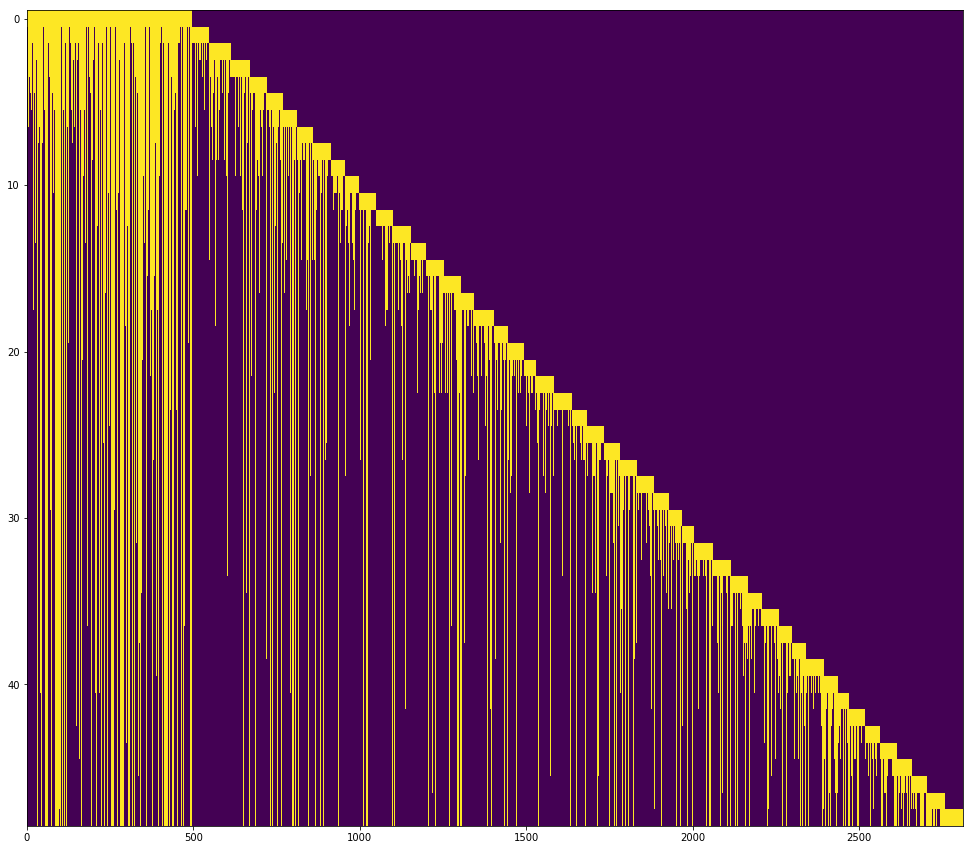

In [29]:
# print(np.where(bool_pvm==0))
plt.imshow(boolean_point_view_matrix,aspect=50)
plt.show()

In [30]:
threshold = 3
boolean_point_view_matrix, point_view_matrix = densify(boolean_point_view_matrix, point_view_matrix, threshold)

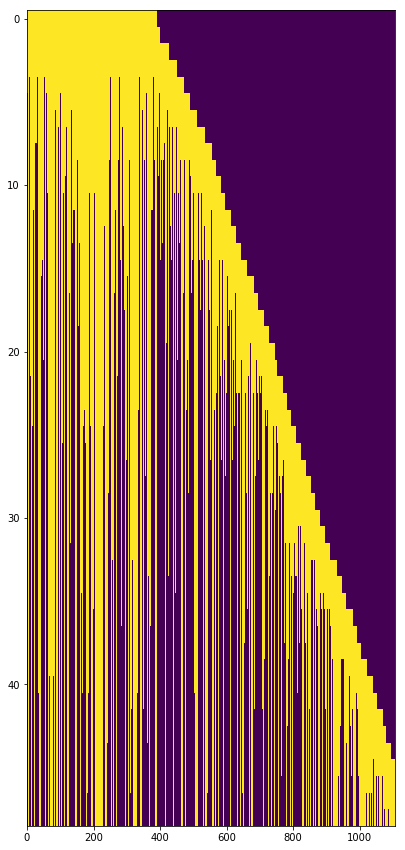

In [31]:
# print(np.where(bool_pvm==0))
plt.imshow(boolean_point_view_matrix,aspect=50)
plt.show()

In [32]:
# distance_thresholds = [1, 3, 7, 1000]
# methods = ['RANSAC', 'None']
# for threshold in distance_thresholds:
#     for method in methods:
#         name = f'distance_{threshold}_method_{method}'
#         point_view_matrix, boolean_point_view_matrix = build_pvm(images_path, 50, method = method, 
#                                                                  distance_threshold=threshold, step=1, 
#                                                                  crossCheck=True, sample_size=20)
#         save_figure(boolean_point_view_matrix, name)

In [33]:
# crossChecks = [True, False]
# features = ['AKAZE', 'SIFT']
# for crossCheck in crossChecks:
#     for feature in features:
#         name = f'crossChecks_{crossCheck}_feature_{feature}'
#         point_view_matrix, boolean_point_view_matrix = build_pvm(images_path, 50, features = feature,
#                                                              distance_threshold=5, step=1, crossCheck=crossCheck)
#         save_figure(boolean_point_view_matrix, name)

In [34]:
# drop_rates = [3, 5, 10]
# for drop_rate in drop_rates:
#     name = f'drop_rate_{drop_rate}'
#     point_view_matrix, boolean_point_view_matrix = build_pvm(images_path, 50, features = feature,
#                                                              distance_threshold=5, step=1, crossCheck=True, method='RANSAC')
    
#     boolean_point_view_matrix, point_view_matrix = densify(boolean_point_view_matrix, point_view_matrix, drop_rate)
#     save_figure(boolean_point_view_matrix, name)

In [35]:
# the following is the procrustes function from scipy.spatial, 
# with the only change that we return the R matrix and s 
from scipy.linalg import orthogonal_procrustes

def procrustes(data1, data2):
    r"""Procrustes analysis, a similarity test for two data sets.
    Each input matrix is a set of points or vectors (the rows of the matrix).
    The dimension of the space is the number of columns of each matrix. Given
    two identically sized matrices, procrustes standardizes both such that:
    - :math:`tr(AA^{T}) = 1`.
    - Both sets of points are centered around the origin.
    Procrustes ([1]_, [2]_) then applies the optimal transform to the second
    matrix (including scaling/dilation, rotations, and reflections) to minimize
    :math:`M^{2}=\sum(data1-data2)^{2}`, or the sum of the squares of the
    pointwise differences between the two input datasets.
    This function was not designed to handle datasets with different numbers of
    datapoints (rows).  If two data sets have different dimensionality
    (different number of columns), simply add columns of zeros to the smaller
    of the two.
    Parameters
    ----------
    data1 : array_like
        Matrix, n rows represent points in k (columns) space `data1` is the
        reference data, after it is standardised, the data from `data2` will be
        transformed to fit the pattern in `data1` (must have >1 unique points).
    data2 : array_like
        n rows of data in k space to be fit to `data1`.  Must be the  same
        shape ``(numrows, numcols)`` as data1 (must have >1 unique points).
    Returns
    -------
    mtx1 : array_like
        A standardized version of `data1`.
    mtx2 : array_like
        The orientation of `data2` that best fits `data1`. Centered, but not
        necessarily :math:`tr(AA^{T}) = 1`.
    disparity : float
        :math:`M^{2}` as defined above.
    Raises
    ------
    ValueError
        If the input arrays are not two-dimensional.
        If the shape of the input arrays is different.
        If the input arrays have zero columns or zero rows.
    See Also
    --------
    scipy.linalg.orthogonal_procrustes
    scipy.spatial.distance.directed_hausdorff : Another similarity test
      for two data sets
    Notes
    -----
    - The disparity should not depend on the order of the input matrices, but
      the output matrices will, as only the first output matrix is guaranteed
      to be scaled such that :math:`tr(AA^{T}) = 1`.
    - Duplicate data points are generally ok, duplicating a data point will
      increase its effect on the procrustes fit.
    - The disparity scales as the number of points per input matrix.
    References
    ----------
    .. [1] Krzanowski, W. J. (2000). "Principles of Multivariate analysis".
    .. [2] Gower, J. C. (1975). "Generalized procrustes analysis".
    Examples
    --------
    >>> from scipy.spatial import procrustes
    The matrix ``b`` is a rotated, shifted, scaled and mirrored version of
    ``a`` here:
    >>> a = np.array([[1, 3], [1, 2], [1, 1], [2, 1]], 'd')
    >>> b = np.array([[4, -2], [4, -4], [4, -6], [2, -6]], 'd')
    >>> mtx1, mtx2, disparity = procrustes(a, b)
    >>> round(disparity)
    0.0
    """
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    mtx2 = np.array(data2, dtype=np.double, copy=True)

    if mtx1.ndim != 2 or mtx2.ndim != 2:
        raise ValueError("Input matrices must be two-dimensional")
    if mtx1.shape != mtx2.shape:
        raise ValueError("Input matrices must be of same shape")
    if mtx1.size == 0:
        raise ValueError("Input matrices must be >0 rows and >0 cols")

    # translate all the data to the origin
    mtx1 -= np.mean(mtx1, 0)
    mtx2 -= np.mean(mtx2, 0)

    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)

    if norm1 == 0 or norm2 == 0:
        raise ValueError("Input matrices must contain >1 unique points")

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    mtx1 /= norm1
    mtx2 /= norm2

    # transform mtx2 to minimize disparity
    R, s = orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s

    # measure the dissimilarity between the two datasets
    disparity = np.sum(np.square(mtx1 - mtx2))
    
#     t = np.mean(mtx1, 0) - s * np.dot(np.mean(mtx1, 0), R.T)

    return mtx1, mtx2, disparity, R, s

In [36]:
from scipy.io import loadmat

def dense_block_matrix(mat, block_size):
    blocks = []
    for i in range(mat.shape[0] - block_size + 1):
        keypoint_count = np.sum(mat[i:i + block_size], 0)
        
        full_matches = np.where(keypoint_count == block_size)[0]
        partial_matches = np.where(keypoint_count < block_size)[0]
        
        d = {'full_matches': full_matches, 'partial_matches': partial_matches}
        blocks.append(d)
        
    return blocks


In [37]:
def normalize_views(t):
    return t - t.mean(1).reshape(-1, 1) # reshape is used for correct broadcasting

# from M x N x 2 -> 2*M x N
def construct_measurment_matrix(m):
    measurment_matrix = np.zeros((2*m.shape[0], m.shape[1]))
    for i in range(m.shape[0]):
        measurment_matrix[2*i] = m[i, :, 0]
        measurment_matrix[2*i+1] = m[i, :, 1]
    return measurment_matrix

# from 2*m x N -> M x N x 2
def deconstruct_measurement_matrix(m):
    M, N = int(m.shape[0] / 2), m.shape[1]
    pvm = np.zeros((M, N, 2))
    for i in range(2*M):
        pvm[int(i / 2), :, i%2] = m[i, :]
    return pvm

def structure_motion_factorization(dense_block):
    U, W, Vt = np.linalg.svd(dense_block)
    U3, W3, Vt3 = U[:, :3], W[:3], Vt[:3, :]
    M = np.sqrt(W3) * U3
    S = (np.sqrt(W3) * Vt3.T).T
    return S, M

# we take as input a M x N x 2 matrix
def get_block_points(block_matrix):
    measurment_matrix = construct_measurment_matrix(block_matrix)
    normalized_block = normalize_views(measurment_matrix)
    S, M = structure_motion_factorization(normalized_block)
    return S.T, M

def affine_transform(St, M):
    L = np.linalg.lstsq(M, np.linalg.pinv(M).T)[0] # take only the least sqares matrix solution
    C = np.linalg.cholesky(L)    
    St = St.dot(np.linalg.inv(C))
    M = M.dot(C)
    return St, M

def select_block(point_view_matrix, blocks, n, block_size):
    return point_view_matrix[n:n+block_size, blocks[n]['full_matches']]

In [38]:
from scipy.io import savemat

def get_point_cloud(point_view_matrix, blocks, block_size, affine_reconstruct=False):
    last_block = select_block(point_view_matrix, blocks, 0, block_size)
    last_points, M = get_block_points(last_block)
    
    # initialize with all points of first block
    final_points = last_points[:]
    final_columns = blocks[0]['full_matches']
    
    Mlist = [M]
    for i in range(1, len(blocks)):
        block_matrix = select_block(point_view_matrix, blocks, i, block_size)

        S, M = get_block_points(block_matrix)
        Mlist.append(M)
        
        common_idxs = np.intersect1d(final_columns, blocks[i]['full_matches'])
        new_idxs = np.array([ np.argwhere(j == blocks[i]['full_matches'])[0][0] for j in common_idxs])
        old_idxs = np.array([ np.argwhere(j == final_columns)[0][0] for j in common_idxs])
        new_points_idxs = np.array([ ii for ii, j in enumerate(blocks[i]['full_matches']) if j not in common_idxs])

        m1, m2, d, R, s = procrustes(final_points[old_idxs], S[new_idxs])

        if new_points_idxs.shape[0] > 0:
            final_points = np.vstack((final_points, s * S[new_points_idxs].dot(R.T)))
            final_columns = np.hstack((final_columns, blocks[i]['full_matches'][new_points_idxs]))
        
    if affine_reconstruct:
        final_points, _ = affine_transform(final_points, np.vstack(Mlist))

    return final_points


In [48]:
# computing the full dense matrix factorization

dense_view_matrix = np.loadtxt('PointViewMatrix.txt')
dense_view_matrix = deconstruct_measurement_matrix(dense_view_matrix)
S, _ = get_block_points(dense_view_matrix)
savemat('dense.mat', {'dense_points' : S})

In [57]:
point_view_matrix, bool_point_view_matrix = build_pvm(images_path, 50, distance_threshold=5, 
                                                         step=1, method='None', crossCheck=True)

blocks = dense_block_matrix(bool_point_view_matrix, 3)
points = get_point_cloud(point_view_matrix, blocks, 3)

savemat('points3.mat', {'points3' : points})

A Jupyter Widget

In [58]:
# point cloud of the first block
first_block = select_block(point_view_matrix, blocks, 0, block_size = 3)
S1, _ = get_block_points(first_block)
savemat('first_block_points.mat', {'first_block_points' : S1})

In [51]:
blocks = dense_block_matrix(bool_point_view_matrix, 4)
points = get_point_cloud(point_view_matrix, blocks, 4)
savemat('points4.mat', {'points4' : points})

In [52]:
blocks = dense_block_matrix(bool_point_view_matrix, 4)
points = get_point_cloud(point_view_matrix, blocks, 4, affine_reconstruct=True)
savemat('points4_affine.mat', {'points4_affine' : points})

/home/hiryugan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [54]:
point_view_matrix, bool_point_view_matrix = build_pvm(images_path, 50, distance_threshold=5, 
                                                         step=1, method='None', crossCheck=True)
bool_point_view_matrix, point_view_matrix = densify(boolean_point_view_matrix, point_view_matrix, threshold)

blocks = dense_block_matrix(bool_point_view_matrix, 4)
points = get_point_cloud(point_view_matrix, blocks, 4)
savemat('points4_densified.mat', {'points4_densified' : points})

A Jupyter Widget

In [ ]:
import matlab.engine

matlab_eng = matlab.engine.start_matlab()
matlab_eng.plot_file('points4_densified.mat', nargout=0)